In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.math import argmax
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os
from gym import spaces

In [2]:
rng = np.random.default_rng(358)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
disc_actions_num = 4

In [5]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [6]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions=1, upper_bound=1, continuous=True, layer1=400, layer2=300, 
              init_weights_min=-0.003, init_weights_max=0.003):
    last_init = tf.random_uniform_initializer(minval=init_weights_min, maxval=init_weights_max)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(disc_actions_num, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    return tf.keras.Model(inputs, outputs)

def get_critic(num_states, num_actions=1, continuous=True, layer1=400, layer2=300):
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(64, activation="relu")(state_input)
    #state_out = layers.Dense(32, activation="relu")(state_out)

    if continuous:
        action_input = layers.Input(shape=(num_actions,))
    else:
        action_input = layers.Input(shape=(disc_actions_num,))
    action_out = layers.Dense(64, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(num_actions)(out)
#     if continuous:
#         outputs = layers.Dense(num_actions)(out)
#     else:
#         outputs = layers.Dense(disc_actions_num)(out)

    return tf.keras.Model([state_input, action_input], outputs)

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [7]:
class Agent:
    def __init__(self, num_states, num_actions=1, lower_bound=-1, upper_bound=1, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2, adam_critic_eps=1e-07,
            adam_actor_eps=1e-07, actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, 
            actor_layer_2=256, critic_layer_1=256, critic_layer_2=256):
        
        self.continuous = continuous
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        if self.continuous:
            self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        else:
            self.action_buffer = np.zeros((self.buffer_capacity, disc_actions_num))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # Also keep track if it is in terminal state (legs on ground)
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        # Epsilon in epsilon-greedy
        self.epsilon = epsilon
        
        self.actor_model = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.critic_model = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.target_actor = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.target_critic = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_actor_eps, amsgrad=actor_amsgrad,
        )
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_critic_eps, amsgrad=critic_amsgrad,
        )
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Calculation of loss and gradients
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            l = losses.MeanSquaredError()
            critic_loss = l(y, critic_value)

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping to avoid exploding and vanishing gradients
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                return self.actor_model(state)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    action = np.zeros(disc_actions_num)
                    action[np.random.randint(0, disc_actions_num, 1)[0]] = 1
                    return action
                else:
                    return self.actor_model(state)

In [9]:
def fixed(x, episode):
    return x

In [10]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07,
            actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, actor_layer_2=256,
            critic_layer_1=256, critic_layer_2=256):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        # Stepcount used for random start
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau, epsilon=epsilon, adam_critic_eps=adam_critic_eps, adam_actor_eps=adam_actor_eps,
                actor_amsgrad=actor_amsgrad, critic_amsgrad=critic_amsgrad, actor_layer_1=actor_layer_1, 
                actor_layer_2=actor_layer_2, critic_layer_1=critic_layer_1, critic_layer_2=critic_layer_2)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                if continuous:
                    state, reward, done, info = env.step(action)
                else:
                    state, reward, done, info = env.step(np.argmax(action))
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground.
                terminal_state = int(not done)#int(not (state[6] and state[7]))
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            true_reward_list[trial].append(true_reward)
            
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, 
                          true_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}".format(
            environment, continuous, 
            timestamp,
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    try:
        plt.savefig('Graphs/' + save_name + '.png')
    except:
        print('save fig fail')
    plt.show()
    
    print('total time:', time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [26]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0, epsilon=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)

            if continuous:
                state, reward, done, info = env.step(action)
            else:
                state, reward, done, info = env.step(np.argmax(action))
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [27]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [13]:
xax = [x for x in range(-600,250)]

In [14]:
def decreasing_std(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

In [15]:
def decreasing_alr(x, episode):
    return max(0, min(0.0002, 0.0002 - (x+500)*(0.0002/700)))

In [16]:
def decreasing_clr(x, episode):
    return max(0, min(0.0004, 0.0004 - (x+500)*(0.0004/700)))

In [17]:
def decreasing_tau(x, episode):
    return max(0, min(0.002, 0.002 - (x+500)*(0.002/700)))

In [18]:
def decreasing_eps(x, episode):
    return max(0, min(0.3, 0.3 - (x+500)*(0.3/700)))

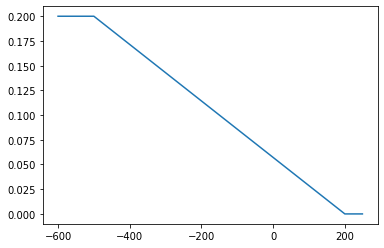

In [19]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,250)])

In [20]:
#test(render=True, continuous=False, actor_weights='Weights/actor-trial0_LunarLander-v2_500_20000_64_0.3_0.0002_0.0001_0.99_0.001_1_fixed_fixed_fixed_fixed_fixed_fixed_20_False_200_False_5000_-10.0_False_15.0_1.5_0.2.h5')

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 1.45 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 0.52 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 0.51 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 0.47 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 0.54 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 0.41 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 0.56 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 0.46 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.40 * step 643
Ep 9 

Ep 73 * AvgReward -206.95 * true AvgReward -206.95 * Reward -103.74 * True Reward -103.74 * time 9.96 * step 17512
Ep 74 * AvgReward -203.97 * true AvgReward -203.97 * Reward -141.76 * True Reward -141.76 * time 9.70 * step 18512
Ep 75 * AvgReward -203.42 * true AvgReward -203.42 * Reward -125.01 * True Reward -125.01 * time 10.30 * step 19512
Ep 76 * AvgReward -191.23 * true AvgReward -191.23 * Reward -119.81 * True Reward -119.81 * time 10.02 * step 20512
Ep 77 * AvgReward -190.23 * true AvgReward -190.23 * Reward -82.08 * True Reward -82.08 * time 6.84 * step 21225
Ep 78 * AvgReward -153.84 * true AvgReward -153.84 * Reward -147.62 * True Reward -147.62 * time 10.18 * step 22225
Ep 79 * AvgReward -121.27 * true AvgReward -121.27 * Reward -125.43 * True Reward -125.43 * time 5.94 * step 22863
Ep 80 * AvgReward -126.69 * true AvgReward -126.69 * Reward -209.67 * True Reward -209.67 * time 4.79 * step 23426
Ep 81 * AvgReward -136.05 * true AvgReward -136.05 * Reward -219.77 * True Rewa

Ep 145 * AvgReward -49.22 * true AvgReward -49.22 * Reward -72.79 * True Reward -72.79 * time 5.43 * step 70177
Ep 146 * AvgReward -60.05 * true AvgReward -60.05 * Reward -50.49 * True Reward -50.49 * time 3.07 * step 70568
Ep 147 * AvgReward -60.47 * true AvgReward -60.47 * Reward -11.63 * True Reward -11.63 * time 1.78 * step 70798
Ep 148 * AvgReward -56.45 * true AvgReward -56.45 * Reward -12.11 * True Reward -12.11 * time 2.09 * step 71064
Ep 149 * AvgReward -56.62 * true AvgReward -56.62 * Reward -79.77 * True Reward -79.77 * time 4.90 * step 71651
Ep 150 * AvgReward -47.05 * true AvgReward -47.05 * Reward 136.65 * True Reward 136.65 * time 6.13 * step 72383
Ep 151 * AvgReward -36.65 * true AvgReward -36.65 * Reward -5.98 * True Reward -5.98 * time 1.52 * step 72571
Ep 152 * AvgReward -35.29 * true AvgReward -35.29 * Reward -67.24 * True Reward -67.24 * time 4.85 * step 73146
Ep 153 * AvgReward -35.73 * true AvgReward -35.73 * Reward -115.26 * True Reward -115.26 * time 7.24 * ste

Ep 219 * AvgReward 50.37 * true AvgReward 50.37 * Reward -84.09 * True Reward -84.09 * time 1.23 * step 97124
Ep 220 * AvgReward 35.14 * true AvgReward 35.14 * Reward -62.29 * True Reward -62.29 * time 1.54 * step 97325
Ep 221 * AvgReward 28.18 * true AvgReward 28.18 * Reward 9.09 * True Reward 9.09 * time 1.66 * step 97541
Ep 222 * AvgReward 14.45 * true AvgReward 14.45 * Reward -60.43 * True Reward -60.43 * time 1.66 * step 97757
Ep 223 * AvgReward 17.50 * true AvgReward 17.50 * Reward 34.07 * True Reward 34.07 * time 1.58 * step 97959
Ep 224 * AvgReward 5.76 * true AvgReward 5.76 * Reward -17.79 * True Reward -17.79 * time 2.27 * step 98227
Ep 225 * AvgReward 7.02 * true AvgReward 7.02 * Reward 213.72 * True Reward 213.72 * time 2.38 * step 98528
Ep 226 * AvgReward -6.28 * true AvgReward -6.28 * Reward -24.27 * True Reward -24.27 * time 1.46 * step 98710
Ep 227 * AvgReward -6.01 * true AvgReward -6.01 * Reward -79.63 * True Reward -79.63 * time 1.20 * step 98867
Ep 228 * AvgReward -

Ep 292 * AvgReward 115.96 * true AvgReward 115.96 * Reward 162.21 * True Reward 162.21 * time 4.58 * step 124989
Ep 293 * AvgReward 113.56 * true AvgReward 113.56 * Reward 220.67 * True Reward 220.67 * time 3.43 * step 125424
Ep 294 * AvgReward 117.54 * true AvgReward 117.54 * Reward 246.49 * True Reward 246.49 * time 4.29 * step 125957
Ep 295 * AvgReward 117.20 * true AvgReward 117.20 * Reward 193.66 * True Reward 193.66 * time 2.77 * step 126311
Ep 296 * AvgReward 129.51 * true AvgReward 129.51 * Reward 138.02 * True Reward 138.02 * time 4.07 * step 126815
Ep 297 * AvgReward 127.18 * true AvgReward 127.18 * Reward 231.62 * True Reward 231.62 * time 5.08 * step 127448
Ep 298 * AvgReward 150.81 * true AvgReward 150.81 * Reward 264.07 * True Reward 264.07 * time 3.36 * step 127875
Ep 299 * AvgReward 164.96 * true AvgReward 164.96 * Reward 230.03 * True Reward 230.03 * time 3.87 * step 128358
Ep 300 * AvgReward 175.16 * true AvgReward 175.16 * Reward 193.80 * True Reward 193.80 * time 3.

Ep 365 * AvgReward 91.82 * true AvgReward 91.82 * Reward 61.66 * True Reward 61.66 * time 8.77 * step 172535
Ep 366 * AvgReward 94.82 * true AvgReward 94.82 * Reward 45.24 * True Reward 45.24 * time 9.08 * step 173535
Ep 367 * AvgReward 89.43 * true AvgReward 89.43 * Reward 76.65 * True Reward 76.65 * time 8.61 * step 174535
Ep 368 * AvgReward 92.55 * true AvgReward 92.55 * Reward 232.90 * True Reward 232.90 * time 3.78 * step 175005
Ep 369 * AvgReward 104.37 * true AvgReward 104.37 * Reward 221.38 * True Reward 221.38 * time 5.68 * step 175662
Ep 370 * AvgReward 109.79 * true AvgReward 109.79 * Reward 106.17 * True Reward 106.17 * time 8.72 * step 176662
Ep 371 * AvgReward 111.40 * true AvgReward 111.40 * Reward 249.70 * True Reward 249.70 * time 4.92 * step 177266
Ep 372 * AvgReward 121.82 * true AvgReward 121.82 * Reward 226.25 * True Reward 226.25 * time 4.81 * step 177826
Ep 373 * AvgReward 114.75 * true AvgReward 114.75 * Reward 88.36 * True Reward 88.36 * time 9.20 * step 178826

Ep 438 * AvgReward 126.92 * true AvgReward 126.92 * Reward 20.33 * True Reward 20.33 * time 9.48 * step 221019
Ep 439 * AvgReward 119.08 * true AvgReward 119.08 * Reward 71.36 * True Reward 71.36 * time 9.12 * step 222019
Ep 440 * AvgReward 133.25 * true AvgReward 133.25 * Reward 214.97 * True Reward 214.97 * time 4.51 * step 222563
Ep 441 * AvgReward 128.02 * true AvgReward 128.02 * Reward 72.83 * True Reward 72.83 * time 8.92 * step 223563
Ep 442 * AvgReward 126.42 * true AvgReward 126.42 * Reward 200.56 * True Reward 200.56 * time 4.10 * step 224053
Ep 443 * AvgReward 126.06 * true AvgReward 126.06 * Reward 147.04 * True Reward 147.04 * time 6.92 * step 224826
Ep 444 * AvgReward 113.38 * true AvgReward 113.38 * Reward -91.96 * True Reward -91.96 * time 0.98 * step 224949
Ep 445 * AvgReward 105.75 * true AvgReward 105.75 * Reward 24.03 * True Reward 24.03 * time 9.51 * step 225949
Ep 446 * AvgReward 104.63 * true AvgReward 104.63 * Reward 166.34 * True Reward 166.34 * time 5.32 * ste

Ep 511 * AvgReward 132.43 * true AvgReward 132.43 * Reward 207.49 * True Reward 207.49 * time 7.32 * step 262001
Ep 512 * AvgReward 140.41 * true AvgReward 140.41 * Reward 87.96 * True Reward 87.96 * time 8.45 * step 263001
Ep 513 * AvgReward 141.20 * true AvgReward 141.20 * Reward 190.58 * True Reward 190.58 * time 4.61 * step 263583
Ep 514 * AvgReward 142.21 * true AvgReward 142.21 * Reward 247.01 * True Reward 247.01 * time 1.92 * step 263835
Ep 515 * AvgReward 128.66 * true AvgReward 128.66 * Reward -33.92 * True Reward -33.92 * time 8.28 * step 264835
Ep 516 * AvgReward 145.63 * true AvgReward 145.63 * Reward 237.90 * True Reward 237.90 * time 2.74 * step 265208
Ep 517 * AvgReward 149.61 * true AvgReward 149.61 * Reward 259.63 * True Reward 259.63 * time 3.47 * step 265683
Ep 518 * AvgReward 148.55 * true AvgReward 148.55 * Reward 221.24 * True Reward 221.24 * time 6.31 * step 266394
Ep 519 * AvgReward 152.06 * true AvgReward 152.06 * Reward 252.07 * True Reward 252.07 * time 4.46

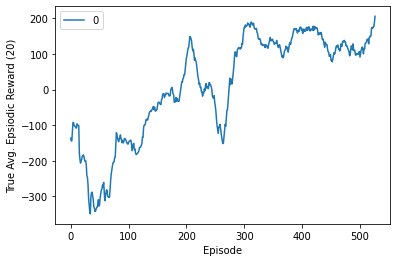

total time: 2306.5955526828766 s


In [22]:
run(total_trials=1, total_episodes=1000, gamma=0.999, buffer_capacity=200000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=1000, continuous=False, epsilon_func=decreasing_eps, actor_lr_func=decreasing_alr,
    critic_lr_func=decreasing_clr, tau_func=decreasing_tau)

11.400798082351685s
4.334111452102661s
4.648845434188843s
4.552043199539185s
4.198412895202637s
4.4727113246917725s
4.578359603881836s
4.693156480789185s
7.070360898971558s
6.610001802444458s


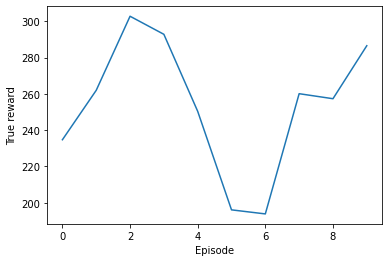

In [28]:
test(render=True, continuous=False, actor_weights='Weights/actor-trial0_LunarLander-v2_False_2022.8.14.0.41.6.h5')